## Classical solutions

In [ ]:
import ......... 

In [14]:
def vqe_function(geometry, basis):
    backend = Aer.get_backend("statevector_simulator")
    optimizer = COBYLA(maxiter=40)
    
    two_qubit_reduction = True
    qubit_mapping = 'parity'
    
    charge = 1
    spin = 0
    driver = PySCFDriver(atom = geometry,
                         unit=UnitsType.ANGSTROM, spin = spin,
                         charge=charge, basis=basis,hf_method=HFMethodType.RHF)
    
    molecule = driver.run()
    
    shift = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_orbitals = molecule.num_orbitals
    num_spin_orbitals = num_orbitals*2
    
    
    core = Hamiltonian(transformation=TransformationType.FULL, qubit_mapping=QubitMappingType.PARITY, 
                   two_qubit_reduction=two_qubit_reduction, freeze_core=False)

    qubitOp, aux_ops = core.run(molecule)
    
    initial_state = HartreeFock(num_spin_orbitals, 
                                num_particles, 
                                qubit_mapping,
                                two_qubit_reduction)
    
    var_form = UCCSD(num_orbitals=num_spin_orbitals,
                        num_particles=num_particles,
                        initial_state=initial_state,
                        qubit_mapping=qubit_mapping,
                        two_qubit_reduction=two_qubit_reduction,
                        z2_symmetries=None)
    
    init_parm = np.zeros(var_form.num_parameters)
    vqe = VQE(qubitOp, var_form, optimizer, initial_point=init_parm)
    vqe_result_tot = vqe.run(backend)
    return np.real(vqe_result_tot['eigenvalue'] + shift)

In [ ]:
#import numpy as np
from pyscf import gto,scf,ao2mo,mp,cc,fci,tools
#import matplotlib.pyplot as plt

dist = np.arange(0.3, 3.5, .1)
alt=np.sqrt(dist**2 - (dist/2)**2)
basis = 'sto-6g' #'sto-6g' '6-31g' 'cc-pvdz' 'aug-cc-pvdz' ,...


energies = {}

energies["HF"] = []
energies["FCI"] = []
energies["MP2"] = []
energies["CCSD"] = []
energies["VQE"] = []


for i in range(len(dist)):
    
    geometry = "H .0 .0 .0; H .0 .0 " + str(dist[i]) + "; H .0 " + str(alt[i]) + " " + str(dist[i]/2)
    mol = gto.M(atom=geometry,charge=1,spin=0,basis=basis,symmetry=True,verbose=0)
    
    mf  = scf.RHF(mol)
    Ehf = mf.kernel() #<- chiamando il kernel otteniamo l'energia calcolata dal metodo
    energies["HF"].append(Ehf)
    
    fci_h3 = fci.FCI(mf)  #<- nei metodi correlati passiamo come argomento un conto di campo medio, HF
    e_fci = fci_h3.kernel()[0]
    energies["FCI"].append(e_fci)
    
    mp2   = mp.MP2(mf)
    e_mp2 = mp2.kernel()[0]
    e_mp2 += Ehf # <- questa linea è necessaria perchè MP2 generalmente mostra l'energia di differenza con HF
    energies["MP2"].append(e_mp2)
    
    ccsd_h3 = cc.CCSD(mf)
    e_ccsd  = ccsd_h3.kernel()[0]
    e_ccsd += Ehf # <- questa linea è necessaria perchè CCSD generalmente mostra l'energia di differenza con HF
    energies["CCSD"].append(e_ccsd)
    
    
    vqe_result = vqe_function(geometry, basis='sto-6g')
    energies["VQE"].append(vqe_result)

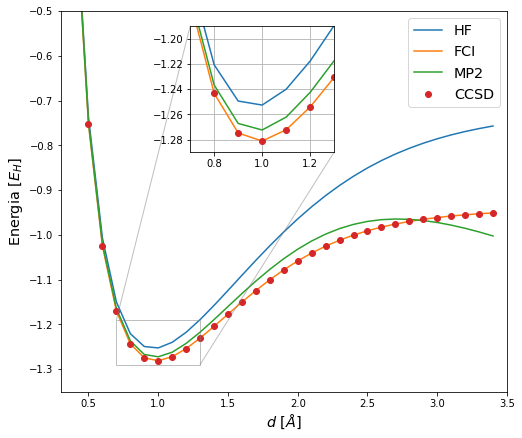

In [6]:
dist = np.arange(0.3, 3.5, .1)


fig, ax = plt.subplots(figsize=[8, 7])

for (method,E) in energies.items():
    if (method == "VQE"):
        #sub_axes.plot(dist,E,'o:',label=method)
        a=4
    elif (method == "FCI"):
        plt.plot(dist,E,'-',label=method)
    elif method == "CCSD":
        plt.plot(dist,E,'o',label=method)
    else:
        plt.plot(dist,E,label=method)
    
#plt.plot(alt,energies["HF"])
plt.xlabel(r"$d$ $[\AA]$", fontsize = 'x-large')
plt.ylabel(r"Energia $[E_H]$", fontsize = 'x-large')
plt.ylim([-1.35, -0.5])
plt.xlim([0.3, 3.5])
plt.legend(fontsize = 'x-large')

sub_axes = plt.axes([.35, .6, .25, .25])     

sub_axes.axis(xmin=0.7,xmax=1.3)
sub_axes.axis(ymin=-1.29,ymax=-1.19)

for (method,E) in energies.items():
    if (method == "VQE"):
        #sub_axes.plot(dist,E,'o:',label=method)
        a=4
    elif (method == "FCI"):
        sub_axes.plot(dist,E,'-',label=method)
    elif method == "CCSD":
        sub_axes.plot(dist,E,'o',label=method)
    else:
        sub_axes.plot(dist,E,label=method)

ax.indicate_inset_zoom(sub_axes)

plt.grid()

plt.savefig('classicals.pdf')
plt.show()